In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import warnings
warnings.filterwarnings("ignore")

#### Define constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

#### Prepare Traning Data

In [3]:
filenames = os.listdir("E:/Data science/projects/Machine learning assignment/project 18/16262924/DS May - 04th Nov/Train-test Data Files/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

cad_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
cad_df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0


In [5]:
cad_df.tail()

,filename,category
397,dog.95.jpg,1
398,dog.96.jpg,1
399,dog.97.jpg,1
400,dog.98.jpg,1
401,dog.99.jpg,1


#### total count

<Axes: >

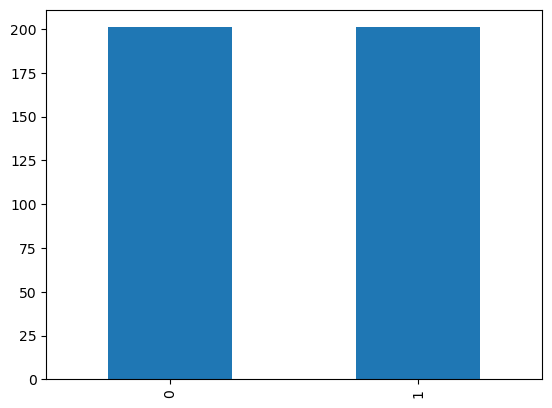

In [6]:
cad_df['category'].value_counts().plot.bar()

#### sample

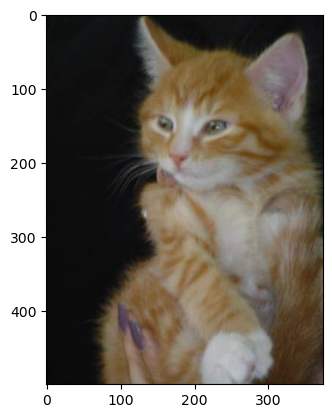

In [7]:
sample = random.choice(filenames)
image = load_img("E:/Data science/projects/Machine learning assignment/project 18/16262924/DS May - 04th Nov/Train-test Data Files/train/"+sample)
plt.imshow(image)

#### build model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: This represent input image data. It will reshape image into single diminsion array.
* **Conv Layer**: it will extract features from image.
* **Pooling Layer**: This layer reduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)      

#### callbacks

#### Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

#### Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [9]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

#### prepare data

In [10]:
cad_df["category"] = cad_df["category"].replace({0: 'cat', 1: 'dog'}) 

In [11]:
train_cad_df, validate_cad_df = train_test_split(cad_df, test_size=0.20, random_state=42)
train_cad_df = train_cad_df.reset_index(drop=True)
validate_cad_df = validate_cad_df.reset_index(drop=True)

<Axes: >

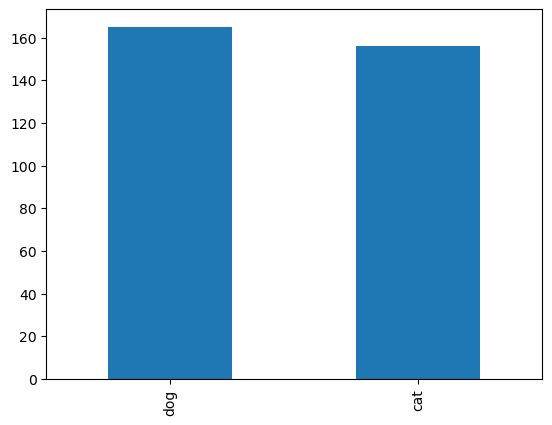

In [12]:
train_cad_df['category'].value_counts().plot.bar()

<Axes: >

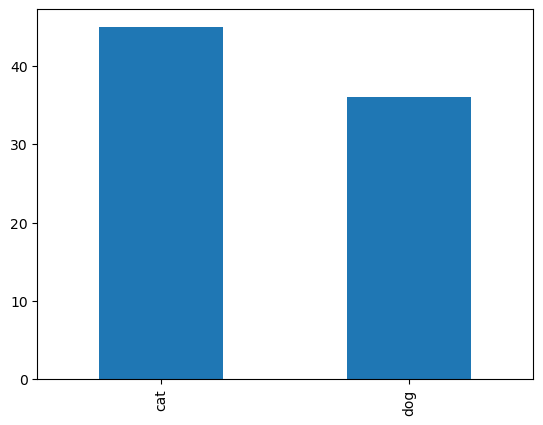

In [13]:
validate_cad_df['category'].value_counts().plot.bar()

In [14]:
total_train = train_cad_df.shape[0]
total_validate = validate_cad_df.shape[0]
batch_size=15

##### training generator

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_cad_df, 
    "E:/Data science/projects/Machine learning assignment/project 18/16262924/DS May - 04th Nov/Train-test Data Files/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 321 validated image filenames belonging to 2 classes.


#### validation generator

In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_cad_df, 
    "E:/Data science/projects/Machine learning assignment/project 18/16262924/DS May - 04th Nov/Train-test Data Files/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 81 validated image filenames belonging to 2 classes.


#### how generator works

In [17]:
example_cad_df = train_cad_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_cad_df, 
    "E:/Data science/projects/Machine learning assignment/project 18/16262924/DS May - 04th Nov/Train-test Data Files/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


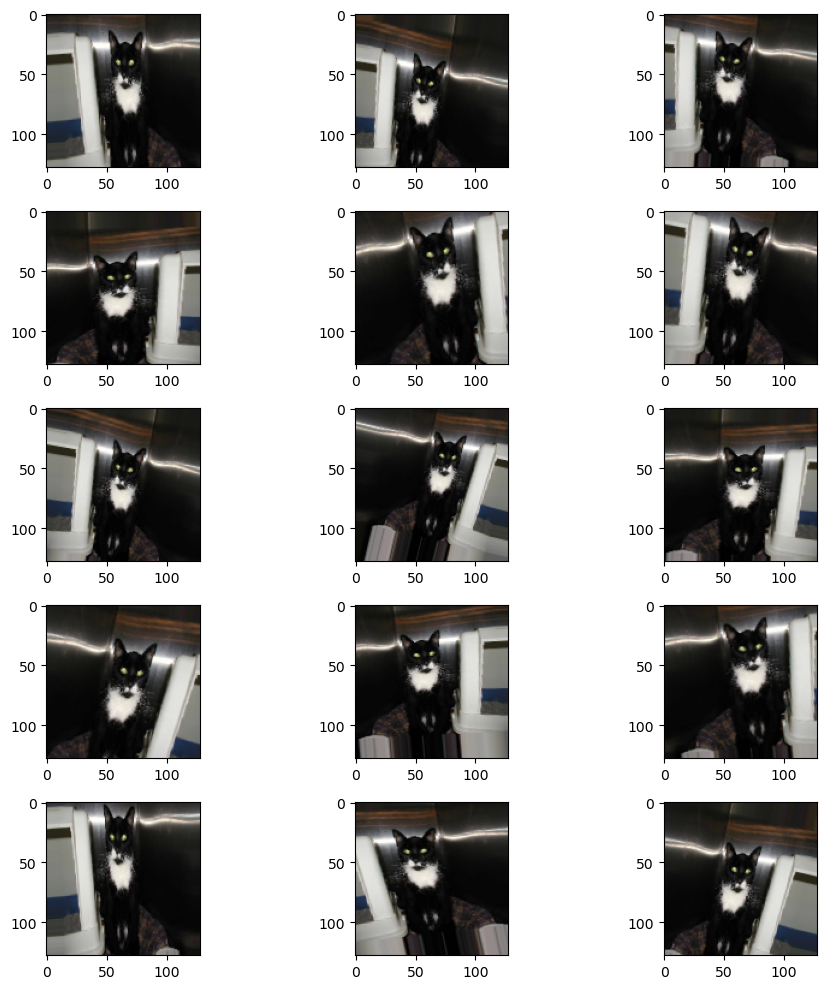

In [18]:
plt.figure(figsize=(10, 10))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### fit model

In [19]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/50


21/21 [==============================] - 12s 453ms/step - loss: 1.6098 - accuracy: 0.5556 - val_loss: 2.8277 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 10s 456ms/step - loss: 1.1962 - accuracy: 0.5327 - val_loss: 8.8887 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 16s 728ms/step - loss: 1.0232 - accuracy: 0.5980 - val_loss: 12.7956 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.9466 - accuracy: 0.6078
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 16s 743ms/step - loss: 0.9466 - accuracy: 0.6078 - val_loss: 8.8432 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 17s 774ms/step - loss: 0.8265 - accuracy: 0.6797 - val_loss: 8.1604 - val_accuracy: 0.5333 - lr: 5.0000e-04
Epoch 6/50
21/21 [==============================] - ET

### visualize

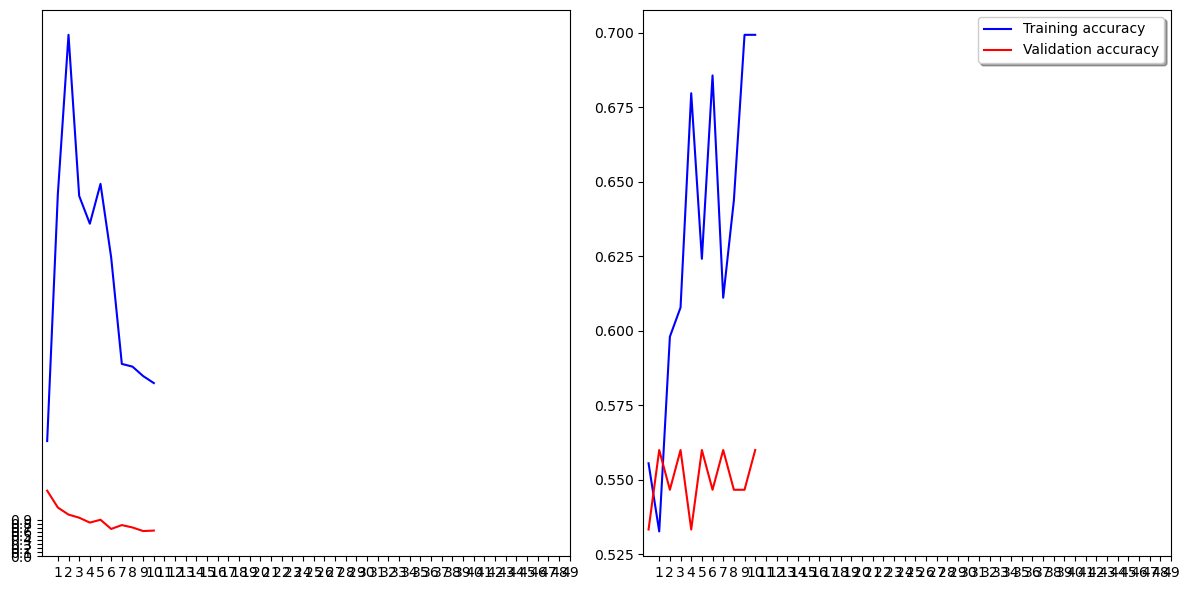

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='r', label="Training loss")
ax1.plot(history.history['val_loss'], color='b', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(10):
    all_test_images = os.listdir("E:/Data science/projects/Machine learning assignment/project 18/16262924/DS May - 04th Nov/Train-test Data Files/test")
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'E:/Data science/projects/Machine learning assignment/project 18/16262924/DS May - 04th Nov/Train-test Data Files/test/{random_image}')
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(['cat','dog'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 298ms/step
dog
1/1 [==============================] - 0s 31ms/step
dog
1/1 [==============================] - 0s 31ms/step
dog
1/1 [==============================] - 0s 41ms/step
dog
1/1 [==============================] - 0s 47ms/step
dog
1/1 [==============================] - 0s 47ms/step
dog
1/1 [==============================] - 0s 32ms/step
dog
1/1 [==============================] - 0s 47ms/step
dog
